In [6]:
# Cell 1: Imports and setup
import crflux.models as pm
import matplotlib.pyplot as plt
import numpy as np
import os
from MCEq.core import MCEqRun

print("Setting up electron neutrino angular flux analysis...")

# Define the models we'll compare
interaction_models = ['SIBYLL23C', 'EPOSLHC']
primary_model = (pm.HillasGaisser2012, "H3a")
mag = 3  # E^3 weighting

print(f"Interaction Models: {interaction_models}")
print(f"Primary Model: HillasGaisser2012(H3a)")


Setting up electron neutrino angular flux analysis...
Interaction Models: ['SIBYLL23C', 'EPOSLHC']
Primary Model: HillasGaisser2012(H3a)


In [7]:
# Cell 2: Calculate fluxes with detailed angular coverage
print("Calculating fluxes with detailed angular coverage...")

# Calculate at high angular resolution for interpolation
angles_detailed = np.arange(0, 91, 1)  # 1° steps from 0° to 90°
print(f"Calculating at {len(angles_detailed)} angles: {angles_detailed[0]}° to {angles_detailed[-1]}°")

# Storage for detailed results
detailed_flux_data = {}
e_grid = None

print("\n" + "="*60)
print("STARTING DETAILED FLUX CALCULATION")
print("="*60)

for int_model in interaction_models:
    print(f"\nProcessing interaction model: {int_model}")
    
    try:
        # Initialize MCEq
        mceq_run = MCEqRun(
            interaction_model=int_model,
            primary_model=primary_model,
            theta_deg=0.0
        )
        
        # Set energy grid on first successful run
        if e_grid is None:
            e_grid = mceq_run.e_grid
        
        # Initialize storage
        detailed_flux_data[int_model] = {
            'angles_deg': [],
            'angles_cos': [],
            'fluxes': []
        }
        
        # Calculate flux for each angle
        successful_angles = 0
        for theta_deg in angles_detailed:
            try:
                mceq_run.set_theta_deg(theta_deg)
                mceq_run.solve()
                
                # Get E^3-weighted electron neutrino flux (nue + antinue)
                flux_total = (mceq_run.get_solution('total_nue', mag) + 
                            mceq_run.get_solution('total_antinue', mag))
                
                detailed_flux_data[int_model]['angles_deg'].append(theta_deg)
                detailed_flux_data[int_model]['angles_cos'].append(np.cos(np.radians(theta_deg)))
                detailed_flux_data[int_model]['fluxes'].append(flux_total)
                successful_angles += 1
                
                if successful_angles % 20 == 0:
                    print(f"  {theta_deg:.0f}° ", end="")
                
            except Exception as e:
                continue
        
        print(f"\n✓ {int_model}: Completed {successful_angles}/{len(angles_detailed)} angles")
        del mceq_run
        
    except Exception as e:
        print(f"✗ {int_model} initialization failed: {str(e)[:50]}...")
        continue

print(f"\nDetailed flux calculation completed!")

Calculating fluxes with detailed angular coverage...
Calculating at 91 angles: 0° to 90°

STARTING DETAILED FLUX CALCULATION

Processing interaction model: SIBYLL23C
MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
  19°   39°   59°   79° 
✓ SIBYLL23C: Completed 91/91 angles

Processing interaction model: EPOSLHC
MCEqRun::set_interaction_model(): EPOSLHC
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
  19°   39°   59°   79° 
✓ EPOSLHC: Completed 91/91 angles

Detailed flux calculation completed!


In [18]:
# Cell 3: Convert to cosine space with 20 steps and calculate bin/total ratios
print("\nConverting to cosine space with 20 steps and calculating bin/total flux ratios...")

# Define our two angular bins
angular_bins = [(0, 45), (45, 90)]
print(f"Using 2 angular bins: {angular_bins[0]} and {angular_bins[1]}")

# Convert angular bins to cosine ranges
cos_ranges = []
for start_deg, end_deg in angular_bins:
    start_cos = np.cos(np.radians(start_deg))
    end_cos = np.cos(np.radians(end_deg))
    cos_ranges.append((start_cos, end_cos))
    print(f"Bin {start_deg}°-{end_deg}° → cosθ: {start_cos:.3f} to {end_cos:.3f}")

# Create 20 cosine steps in each range
cosine_steps = {}
cosine_angles_deg = {}
for i, (cos_start, cos_end) in enumerate(cos_ranges):
    cosine_steps[i] = np.linspace(cos_start, cos_end, 20)
    cosine_angles_deg[i] = np.degrees(np.arccos(cosine_steps[i]))
    print(f"Bin {i}: 20 cosine steps → {cosine_angles_deg[i][0]:.1f}° to {cosine_angles_deg[i][-1]:.1f}°")

# Interpolate fluxes to cosine steps and calculate bin/total ratios
final_results = {
    'bins': ['0°-45°', '45°-90°'],
    'bin_centers_deg': [22.5, 67.5],
    'bin_centers_cos': [np.cos(np.radians(22.5)), np.cos(np.radians(67.5))],
    'sibyll_bin_flux': np.zeros((2, len(e_grid))),
    'epos_bin_flux': np.zeros((2, len(e_grid))),
    'sibyll_total_flux': np.zeros(len(e_grid)),
    'epos_total_flux': np.zeros(len(e_grid)),
    'sibyll_bin_total_ratio': np.zeros((2, len(e_grid))),
    'epos_bin_total_ratio': np.zeros((2, len(e_grid))),
    'cosine_angles_per_bin': 20
}

# Process each model
for int_model in detailed_flux_data:
    if not detailed_flux_data[int_model]['fluxes']:
        continue
        
    original_angles = np.array(detailed_flux_data[int_model]['angles_deg'])
    original_fluxes = np.array(detailed_flux_data[int_model]['fluxes'])
    
    # Calculate TOTAL average flux (average over all angles 0-90°)
    total_flux = np.mean(original_fluxes, axis=0)
    
    if int_model == 'SIBYLL23C':
        final_results['sibyll_total_flux'] = total_flux
    elif int_model == 'EPOSLHC':
        final_results['epos_total_flux'] = total_flux
    
    # For each bin, interpolate to cosine steps and average
    for bin_idx in range(2):
        bin_fluxes = []
        
        for cos_angle_deg in cosine_angles_deg[bin_idx]:
            # Interpolate flux at this cosine angle
            interpolated_flux = np.zeros(len(e_grid))
            for e_idx in range(len(e_grid)):
                energy_fluxes = original_fluxes[:, e_idx]
                interpolated_flux[e_idx] = np.interp(cos_angle_deg, original_angles, energy_fluxes)
            
            bin_fluxes.append(interpolated_flux)
        
        # Average over all 20 cosine steps in this bin
        if bin_fluxes:
            avg_bin_flux = np.mean(bin_fluxes, axis=0)
            
            if int_model == 'SIBYLL23C':
                final_results['sibyll_bin_flux'][bin_idx] = avg_bin_flux
                # Calculate bin/total ratio
                final_results['sibyll_bin_total_ratio'][bin_idx] = avg_bin_flux / final_results['sibyll_total_flux']
            elif int_model == 'EPOSLHC':
                final_results['epos_bin_flux'][bin_idx] = avg_bin_flux
                # Calculate bin/total ratio
                final_results['epos_bin_total_ratio'][bin_idx] = avg_bin_flux / final_results['epos_total_flux']

# Print results
for bin_idx in range(2):
    sibyll_avg_ratio = np.mean(final_results['sibyll_bin_total_ratio'][bin_idx])
    epos_avg_ratio = np.mean(final_results['epos_bin_total_ratio'][bin_idx])
    print(f"{final_results['bins'][bin_idx]}:")
    print(f"  SIBYLL - Bin/Total ratio = {sibyll_avg_ratio:.3f}")
    print(f"  EPOS   - Bin/Total ratio = {epos_avg_ratio:.3f}")

print(f"\nCosine conversion and bin/total ratio calculation completed!")


Converting to cosine space with 20 steps and calculating bin/total flux ratios...
Using 2 angular bins: (0, 45) and (45, 90)
Bin 0°-45° → cosθ: 1.000 to 0.707
Bin 45°-90° → cosθ: 0.707 to 0.000
Bin 0: 20 cosine steps → 0.0° to 45.0°
Bin 1: 20 cosine steps → 45.0° to 90.0°
0°-45°:
  SIBYLL - Bin/Total ratio = 0.812
  EPOS   - Bin/Total ratio = 0.699
45°-90°:
  SIBYLL - Bin/Total ratio = 1.223
  EPOS   - Bin/Total ratio = 1.386

Cosine conversion and bin/total ratio calculation completed!


Creating plot with Bin/Total Flux Ratio...


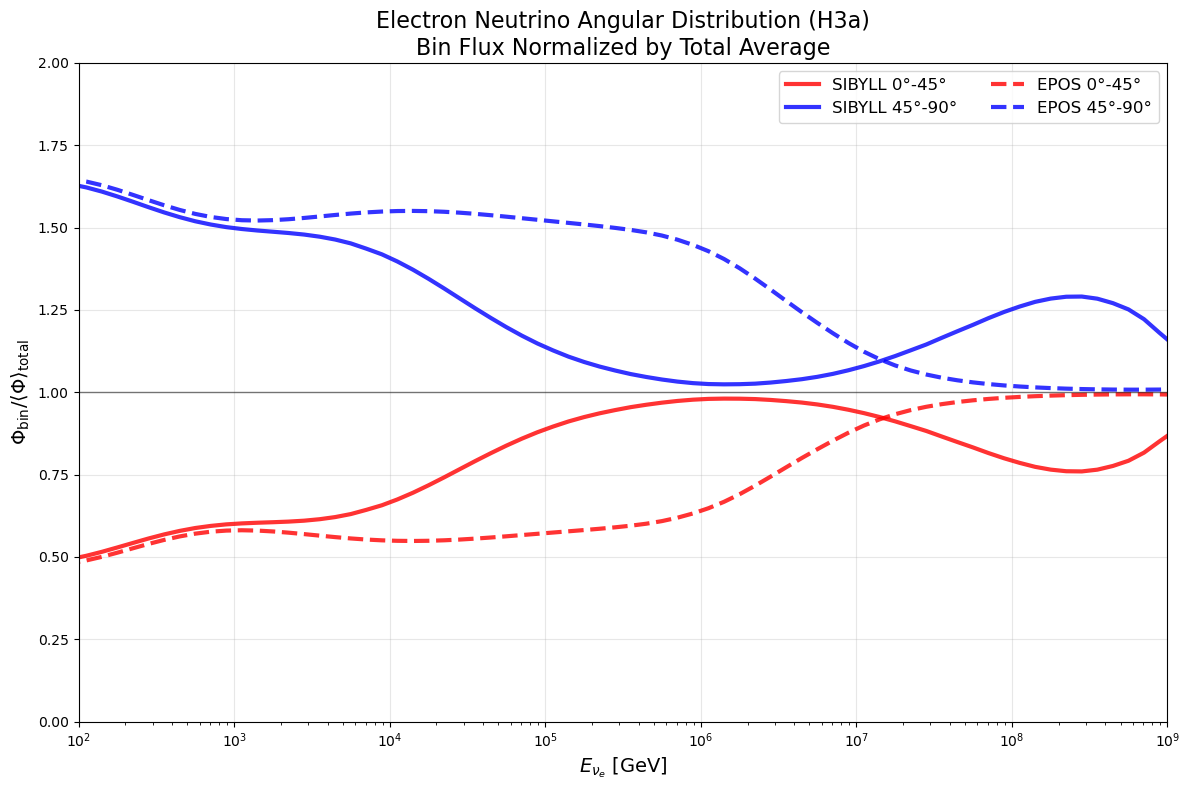

Plot saved to: /Users/gadha/Desktop/electron_neutrino_bin_total_ratio_H3a.pdf


In [22]:
# Cell 4: Create plot with bin/total flux ratios only
print("Creating plot with Bin/Total Flux Ratio...")

# Create figure with single plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# PLOT: Bin/Total Ratio vs Energy - Red for 0-45°/total, Blue for 45-90°/total
colors = ['red', 'blue']  # Red for 0-45°, Blue for 45-90°

# Plot SIBYLL bin/total ratios
for bin_idx in range(2):
    color = colors[bin_idx]
    sibyll_ratio = final_results['sibyll_bin_total_ratio'][bin_idx]
    
    ax.semilogx(e_grid, sibyll_ratio, 
                color=color, linewidth=3, linestyle='-', alpha=0.8,
                label=f'SIBYLL {final_results["bins"][bin_idx]}')

# Plot EPOS bin/total ratios
for bin_idx in range(2):
    color = colors[bin_idx]
    epos_ratio = final_results['epos_bin_total_ratio'][bin_idx]
    
    ax.semilogx(e_grid, epos_ratio, 
                color=color, linewidth=3, linestyle='--', alpha=0.8,
                label=f'EPOS {final_results["bins"][bin_idx]}')

ax.set_xlabel(r'$E_{\nu_e}$ [GeV]', fontsize=14)
ax.set_ylabel(r'$\Phi_{\mathrm{bin}} / \langle\Phi\rangle_{\mathrm{total}}$', fontsize=14)
ax.set_title('Electron Neutrino Angular Distribution (H3a)\nBin Flux Normalized by Total Average', fontsize=16)
ax.legend(fontsize=12, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_xlim(1e2, 1e9)
ax.set_ylim(0.0, 2.0)
ax.axhline(1.0, color='black', linestyle='-', alpha=0.5, linewidth=1, label='Average (1.0)')

plt.tight_layout()

# Save plot
desktop = os.path.join(os.path.expanduser("~"), "Desktop")
save_path = os.path.join(desktop, 'electron_neutrino_bin_total_ratio_H3a.pdf')
plt.savefig(save_path, bbox_inches='tight', dpi=300, facecolor='white')

plt.show()

print(f"Plot saved to: {save_path}")

Creating plot with 0-90° Electron Neutrino Flux...


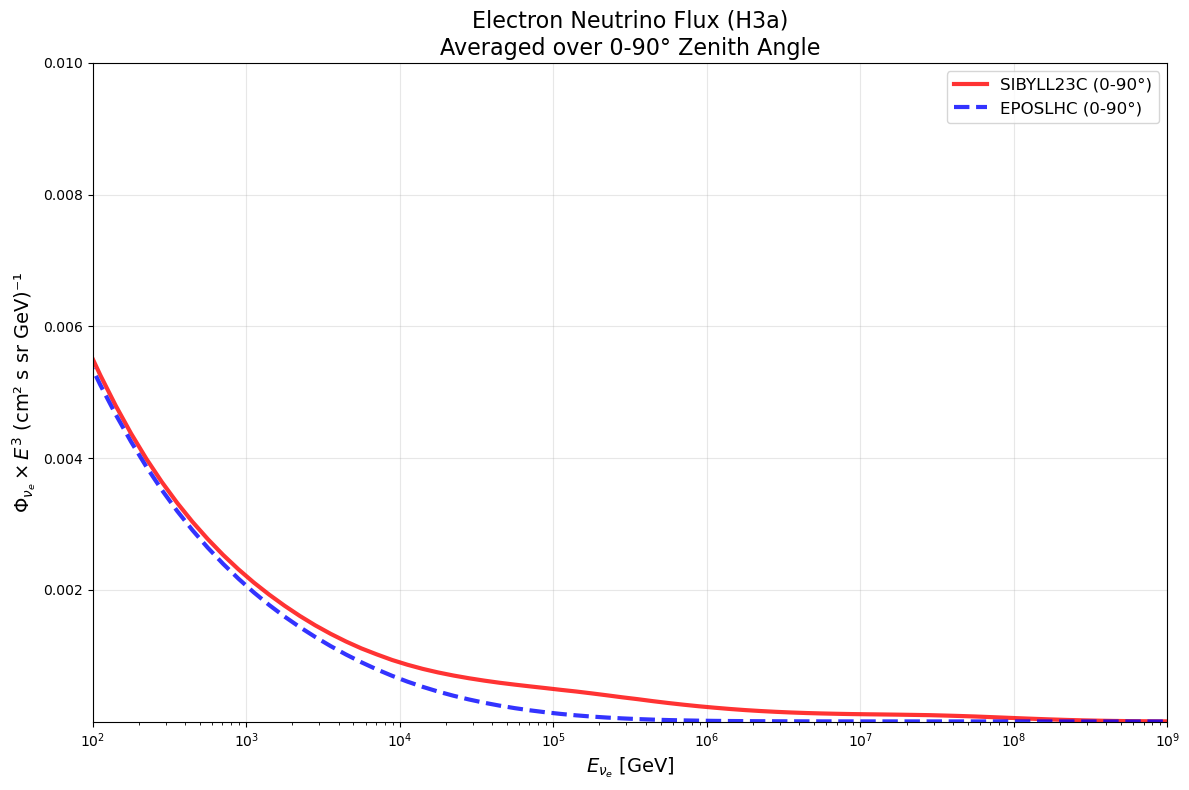

Plot saved to: /Users/gadha/Desktop/electron_neutrino_0_90_flux_H3a.pdf


In [24]:
# Cell 4: Create plot with single 0-90° flux line
print("Creating plot with 0-90° Electron Neutrino Flux...")

# Create figure with single plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Calculate total average flux (0-90°) for both models
sibyll_total_flux = final_results['sibyll_total_flux']
epos_total_flux = final_results['epos_total_flux']

# Plot single lines for each model (0-90° total flux)
ax.semilogx(e_grid, sibyll_total_flux, 
            color='red', linewidth=3, linestyle='-', alpha=0.8,
            label='SIBYLL23C (0-90°)')

ax.semilogx(e_grid, epos_total_flux, 
            color='blue', linewidth=3, linestyle='--', alpha=0.8,
            label='EPOSLHC (0-90°)')

ax.set_xlabel(r'$E_{\nu_e}$ [GeV]', fontsize=14)
ax.set_ylabel(r'$\Phi_{\nu_e} \times E^3$ (cm² s sr GeV)⁻¹', fontsize=14)
ax.set_title('Electron Neutrino Flux (H3a)\nAveraged over 0-90° Zenith Angle', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xlim(1e2, 1e9)
ax.set_ylim(1e-8, 1e-2)

plt.tight_layout()

# Save plot
desktop = os.path.join(os.path.expanduser("~"), "Desktop")
save_path = os.path.join(desktop, 'electron_neutrino_0_90_flux_H3a.pdf')
plt.savefig(save_path, bbox_inches='tight', dpi=300, facecolor='white')

plt.show()

print(f"Plot saved to: {save_path}")